In [1]:
# in case you're modifying external modules while running stuff from this notebook
%load_ext autoreload
%autoreload

In [2]:
! pip install xclim # we don't have this package on compute.impactlab ;

  Using cached xclim-0.32.1-py3-none-any.whl (428 kB)
  Using cached boltons-21.0.0-py2.py3-none-any.whl (193 kB)
  Using cached jsonpickle-2.0.0-py2.py3-none-any.whl (37 kB)


In [3]:
%matplotlib inline 
import xarray as xr
import numpy as np
import dask
import dask.array as da
import dask.distributed as dd
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
import gcsfs 
from matplotlib import cm
import warnings 

from science_validation_manual import *
import rhg_compute_tools.kubernetes as rhgk

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [4]:
ds = read_gcs_zarr('gs://scratch-170cd6ec/3b5573bb-9c01-4888-9141-27e95c41f4cc/e2e-nesm3-dtr-9vt6j-277858176/rechunked.zarr')

In [5]:
ds

,Array,Chunk
Bytes,1.94 GiB,3.06 MiB
Shape,"(8030, 180, 360)","(8030, 10, 10)"
Count,649 Tasks,648 Chunks
Type,float32,numpy.ndarray


In [4]:
client, cluster = rhgk.get_micro_cluster()

In [5]:
cluster.scale(200)
cluster

### Parametrizing ###

In [9]:
tasmin_zarr = read_gcs_zarr('gs://clean-b1dbca25/cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/tasmin/gn/v20181126.zarr')

In [10]:
tasmax_zarr = read_gcs_zarr('gs://clean-b1dbca25/cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/tasmax/gn/v20181126.zarr')

In [21]:
dtr_zarr = xr.Dataset({'dtr': tasmax_zarr['tasmax'] - tasmin_zarr['tasmin']})

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/srv/conda/envs/notebook/lib/python3.8/si

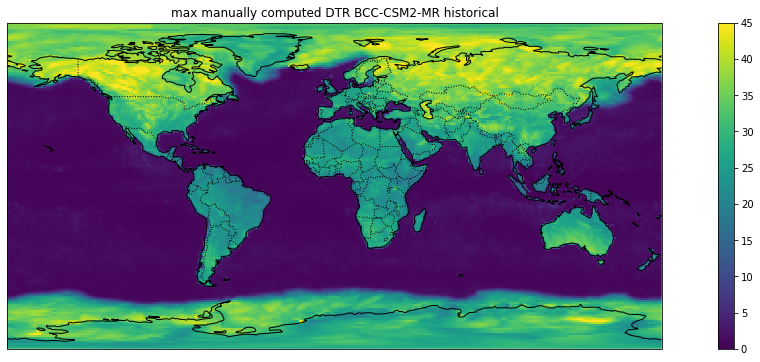

In [27]:
plot_single(ds=dtr_zarr,
                              variable='dtr',
                              metric='max',
                              data_type='manually computed DTR BCC-CSM2-MR historical', 
                              units='K', 
                              vmin=0,
                              vmax=45,
                              xr_func=None,
           cmap_color=cm.viridis)

In [57]:
bc_datadict = {
    'AWI-CM-1-1-MR': 'gs://biascorrected-492e989a/stage/CMIP/AWI/AWI-CM-1-1-MR/historical/r1i1p1f1/day/dtr/gn/v20211223205258.zarr',
    'EC-Earth3-Veg': 'gs://biascorrected-492e989a/stage/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/day/dtr/gr/v20211221191100.zarr',
    'BCC-CSM2-MR': 'gs://biascorrected-492e989a/stage/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/dtr/gn/v20211230093107.zarr'
}

In [58]:
raw_datadict = {
    'AWI-CM-1-1-MR': 'gs://clean-b1dbca25/cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r1i1p1f1/day/dtr/gn/v20181218.zarr',
    'EC-Earth3-Veg': 'gs://clean-b1dbca25/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/day/dtr/gr/v20200225.zarr',
    'BCC-CSM2-MR': 'gs://clean-b1dbca25/cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/dtr/gn/v20181126.zarr'
}

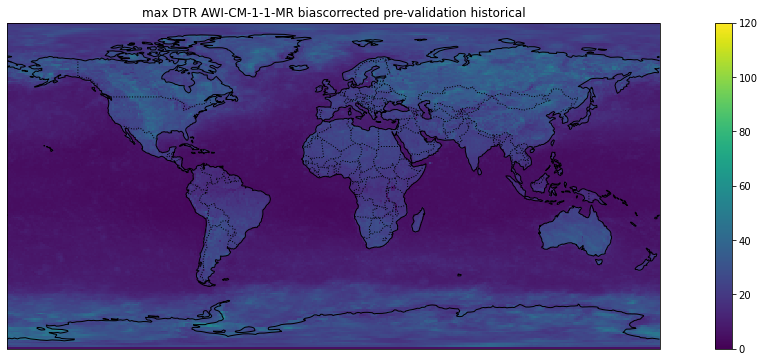

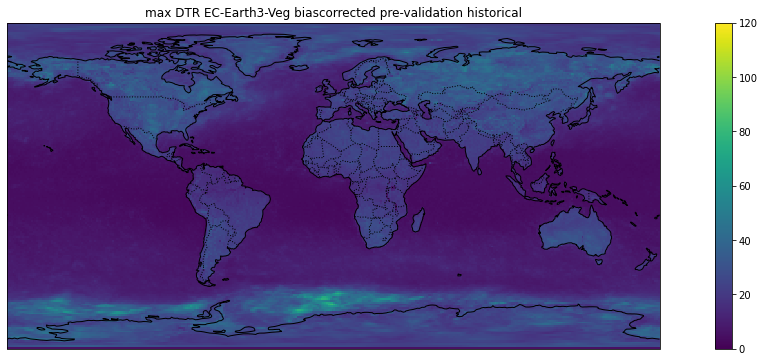

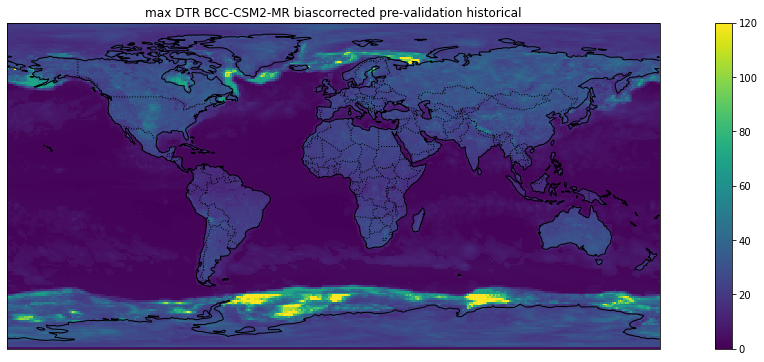

In [61]:
for key, val in bc_datadict.items():
    plot_single(ds=read_gcs_zarr(val),
                              variable='dtr',
                              metric='max',
                              data_type=f'DTR {key} biascorrected pre-validation historical', 
                              units='K', 
                              vmin=0,
                              vmax=120,
                              xr_func=None,
           cmap_color=cm.viridis)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/srv/conda/envs/notebook/lib/python3.8/si

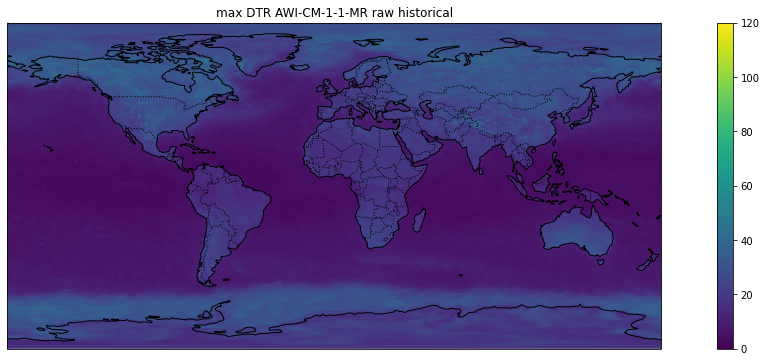

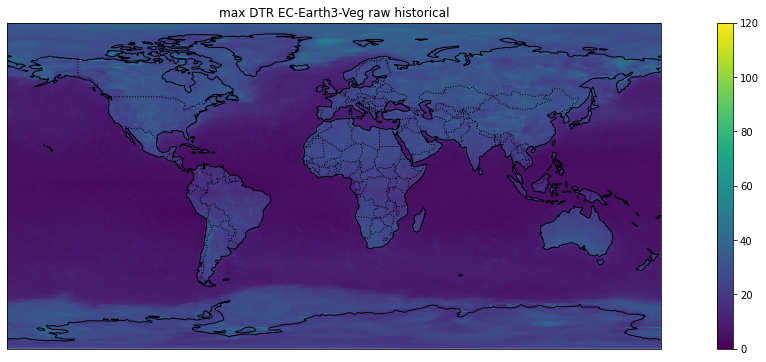

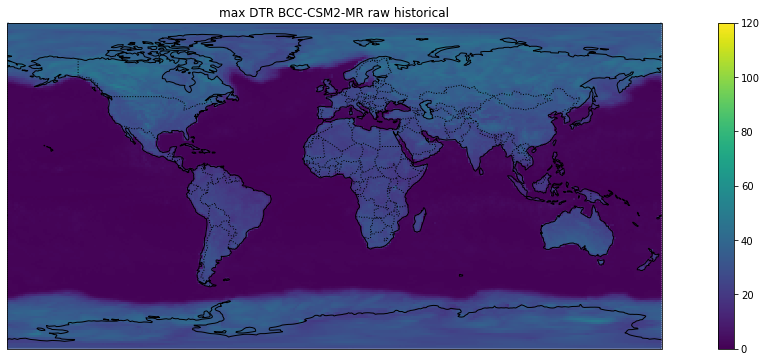

In [62]:
for key, val in raw_datadict.items():
    plot_single(ds=read_gcs_zarr(val),
                              variable='dtr',
                              metric='max',
                              data_type=f'DTR {key} raw historical', 
                              units='K', 
                              vmin=0,
                              vmax=120,
                              xr_func=None,
           cmap_color=cm.viridis)

In [ ]:
plot_single(ds=read_gcs_zarr('gs://clean-b1dbca25/reanalysis/ERA-5/F320/dtr.1995-2015.F320.zarr'),
                          variable='dtr',
                          metric='max',
                          data_type='DTR ERA-5', 
                          units='K', 
                          vmin=0,
                          vmax=45,
                          xr_func=None,
       cmap_color=cm.viridis)

In [ ]:
tasmin_point = tasmin_zarr.sel(lat=70.5, lon=41.5, drop=True).compute()
tasmax_point = tasmax_zarr.sel(lat=70.5, lon=41.5, drop=True).compute()

In [14]:
gcm = 'ACCESS-ESM1-5'

In [17]:
ssp = 'ssp126'
variable = 'pr'
units = 'mm'
years = {'hist': {'start_yr': '1995', 'end_yr': '2014'}, 
              '2020_2040': {'start_yr': '2020', 'end_yr': '2040'}, 
              '2040_2060': {'start_yr': '2040', 'end_yr': '2060'}, 
              '2060_2080': {'start_yr': '2060', 'end_yr': '2080'}, 
              '2080_2100': {'start_yr': '2080', 'end_yr': '2100'}}

In [20]:
# import json
# with open('/home/jovyan/output/e2e_data_paths_pr_ssp370.json') as jsonfile:
#     data_dict_gcms = json.load(jsonfile)
# data_dict = data_dict_gcms['pr']['ssp370'][gcm]
trained_qdm_first = 'gs://scratch-170cd6ec/d5a0f92e-2f4d-4d5b-8691-819db1ca81b4/e2e-access-esm1-5-pr-2s54d-354276140/qdm_model.zarr'
trained_qdm_second = 'gs://scratch-170cd6ec/6447567c-320f-4dea-ba65-8337b4376192/biascorrectdownscale-precipitation-jczlx-2477995662/qdm_model.zarr'
data_dict = {
    'coarse': {
        'ERA-5': 'gs://scratch-170cd6ec/6447567c-320f-4dea-ba65-8337b4376192/biascorrectdownscale-precipitation-jczlx-176806481/rechunked.zarr',
        'bias_corrected':{
            'historical':'gs://biascorrected-492e989a/stage/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/v20220104210146.zarr',
            'ssp126':'gs://biascorrected-492e989a/stage/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp126/r1i1p1f1/day/pr/gn/v20220104210146.zarr'
        },
        'cmip6':{
            'historical':'gs://scratch-170cd6ec/6447567c-320f-4dea-ba65-8337b4376192/biascorrectdownscale-precipitation-jczlx-19767191/rechunked.zarr',
            'ssp126':'gs://scratch-170cd6ec/6447567c-320f-4dea-ba65-8337b4376192/biascorrectdownscale-precipitation-jczlx-1586665123/rechunked.zarr'
        }
    },
    'fine':{
        'downscaled':{
            'historical':'gs://downscaled-288ec5ac/stage/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/v20220104210146.zarr',
            'ssp126':''
        }
    }
}

In [25]:
def plot_diagnostic_climo_periods(ds_future, ssp, years, variable, metric, data_type, units, ds_hist=None, vmin=240, vmax=320, transform = ccrs.PlateCarree(), xr_func=None, cmap_color=cm.cividis):
    """
    plot mean, max, min tasmax, dtr, precip for CMIP6, bias corrected and downscaled data 
    """
    fig, axes = plt.subplots(1, 5, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = cmap_color 
    
    for i, key in enumerate(years): 
        
        # different dataset for historical, select years 
        if i == 0 and ds_hist != None:
            da = ds_hist[variable].sel(time=slice(years[key]['start_yr'], years[key]['end_yr']))
        else:
            da = ds_future[variable].sel(time=slice(years[key]['start_yr'], years[key]['end_yr']))

        if xr_func is not None:
            da = xr_func(da) # some user defined transformation preserving the time dimension

        if metric == 'mean': 
            data = da.mean(dim='time').load()
        elif metric == 'max':
            data = da.max(dim='time').load()
        elif metric == 'min':
            data = da.min(dim='time').load()
        
        
        if ds_hist is not None:
            ind = i
        else: 
            ind = i+1
        
        im = data.plot(ax=axes[ind], 
                  cmap=cmap,
                  transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin, vmax=vmax)

        axes[ind].coastlines()
        axes[ind].add_feature(cfeature.BORDERS, linestyle=":")
        if ind == 2:
            axes[ind].set_title('{} {}, {} \n {}'.format(metric, data_type, ssp, key))
        else: 
            axes[ind].set_title("{}".format(key))
    
    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.02, top=0.9, left=0.05, right=0.95,
                        wspace=0.1, hspace=0.01)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.06])

    # Draw the colorbar
    cbar_title = '{} ({})'.format(variable, units)
    cbar=fig.colorbar(im, cax=cbar_ax, label=cbar_title, orientation='horizontal')

In [26]:
def plot_single(ds, variable, metric, data_type, units, vmin=240, vmax=320, transform = ccrs.PlateCarree(), xr_func=None, cmap_color=cm.cividis):
    """
    plot mean, max, min tasmax, dtr, precip for CMIP6, bias corrected and downscaled data 
    """
    fig, axes = plt.subplots(figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = cmap_color
    
    da = ds[variable]

    if xr_func is not None:
        da = xr_func(da) # some user defined transformation preserving the time dimension

    if metric == 'mean': 
            data = da.mean(dim='time').load()
    elif metric == 'max':
        data = da.max(dim='time').load()
    elif metric == 'min':
        data = da.min(dim='time').load()
    elif isinstance(metric, int):
        data = da.isel({'time': metric})
        metric = f'{metric}_th_time_stamp'
    elif metric == 'q95':
        data = da.quantile(0.95, 'time')
    elif metric == 'q99':
        data = da.quantile(0.99, 'time')

    im = data.plot(cmap=cmap,
                  transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin, vmax=vmax)

    axes.coastlines()
    axes.add_feature(cfeature.BORDERS, linestyle=":")
    axes.set_title('{} {}'.format(metric, data_type))
    fig.colorbar(im)

In [16]:
def read_gcs_zarr(zarr_url, token='/opt/gcsfuse_tokens/impactlab-data.json', check=False, consolidated=True, chunks='auto'):
    """
    takes in a GCSFS zarr url, bucket token, and returns a dataset 
    Note that you will need to have the proper bucket authentication. 
    """
    fs = gcsfs.GCSFileSystem(token=token)
    
    store_path = fs.get_mapper(zarr_url, check=check)
    
    ds = xr.open_zarr(store_path, consolidated=consolidated, chunks=chunks)
    
    ds.close()
    
    return ds 

### mean daily precip ### 

In [ ]:
plot_diagnostic_climo_periods(ds_future=read_gcs_zarr(data_dict['fine']['downscaled'][ssp]),
                              ds_hist=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                              ssp=ssp,
                              years=years,
                              variable=variable,
                              metric='mean',
                              data_type='downscaled', 
                              units=units, 
                              vmin=0,
                              vmax=30,
                              xr_func=None)

In [ ]:
plot_diagnostic_climo_periods(ds_future=read_gcs_zarr(data_dict['coarse']['bias_corrected'][ssp]),
                              ds_hist=read_gcs_zarr(data_dict['coarse']['bias_corrected']['historical']),
                              ssp=ssp,
                              years=years,
                              variable=variable,
                              metric='mean',
                              data_type='bias_corrected', 
                              units=units, 
                              vmin=0,
                              vmax=30,
                              xr_func=None)

In [ ]:
plot_diagnostic_climo_periods(ds_future=read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]),
                              ds_hist=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
                              ssp=ssp,
                              years=years,
                              variable=variable,
                              metric='mean',
                              data_type='cmip6', 
                              units=units, 
                              vmin=0,
                              vmax=30,
                              xr_func=None)

### mean daily precip -- ERA-5 versus biascorrected-historical ### 

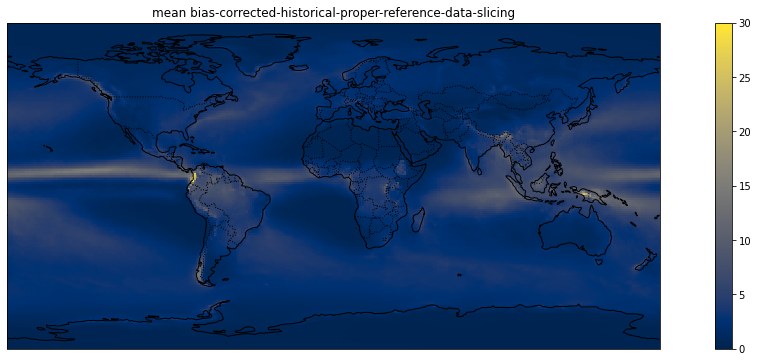

In [43]:
# plot_single(ds=read_gcs_zarr(data_dict['coarse']['ERA-5']),
#                               variable=variable,
#                               metric='mean',
#                               data_type='raw-era-5', 
#                               units=units, 
#                               vmin=0,
#                               vmax=30,
#                               xr_func=None)

# plot_single(ds=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
#                               variable=variable,
#                               metric='mean',
#                               data_type='cmip6-historical', 
#                               units=units, 
#                               vmin=0,
#                               vmax=30,
#                               xr_func=None)

plot_single(ds=read_gcs_zarr(data_dict['coarse']['bias_corrected']['historical']),
                              variable=variable,
                              metric='mean',
                              data_type='bias-corrected-historical-proper-reference-data-slicing', 
                              units=units, 
                              vmin=0,
                              vmax=30,
                              xr_func=None)

### max daily precip ### 

In [ ]:
plot_diagnostic_climo_periods(ds_future=read_gcs_zarr(data_dict['fine']['downscaled'][ssp]),
                              ds_hist=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                              ssp=ssp,
                              years=years,
                              variable=variable,
                              metric='max',
                              data_type='downscaled', 
                              units=units, 
                              vmin=0,
                              vmax=500,
                              xr_func=None)

In [ ]:
plot_diagnostic_climo_periods(ds_future=read_gcs_zarr(data_dict['coarse']['bias_corrected'][ssp]),
                              ds_hist=read_gcs_zarr(data_dict['coarse']['bias_corrected']['historical']),
                              ssp=ssp,
                              years=years,
                              variable=variable,
                              metric='max',
                              data_type='bias_corrected', 
                              units=units, 
                              vmin=0,
                              vmax=500,
                              xr_func=None)

In [ ]:
plot_diagnostic_climo_periods(ds_future=read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]),
                              ds_hist=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
                              ssp=ssp,
                              years=years,
                              variable=variable,
                              metric='max',
                              data_type='cmip6', 
                              units=units, 
                              vmin=0,
                              vmax=500,
                              xr_func=None)

### max daily precip -- ERA-5 vs historical biascorrected ### 

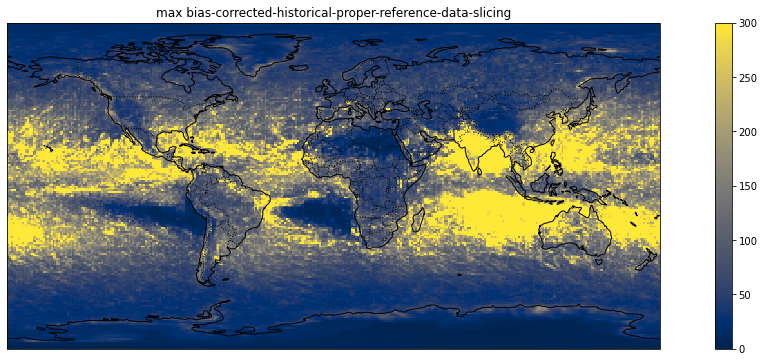

In [44]:
# plot_single(ds=read_gcs_zarr(data_dict['coarse']['ERA-5']),
#                               variable=variable,
#                               metric='max',
#                               data_type='raw-era-5', 
#                               units=units, 
#                               vmin=0,
#                               vmax=300,
#                               xr_func=None)

# plot_single(ds=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
#                               variable=variable,
#                               metric='max',
#                               data_type='cmip6-historical', 
#                               units=units, 
#                               vmin=0,
#                               vmax=300,
#                               xr_func=None)

plot_single(ds=read_gcs_zarr(data_dict['coarse']['bias_corrected']['historical']),
                              variable=variable,
                              metric='max',
                              data_type='bias-corrected-historical-proper-reference-data-slicing', 
                              units=units, 
                              vmin=0,
                              vmax=300,
                              xr_func=None)

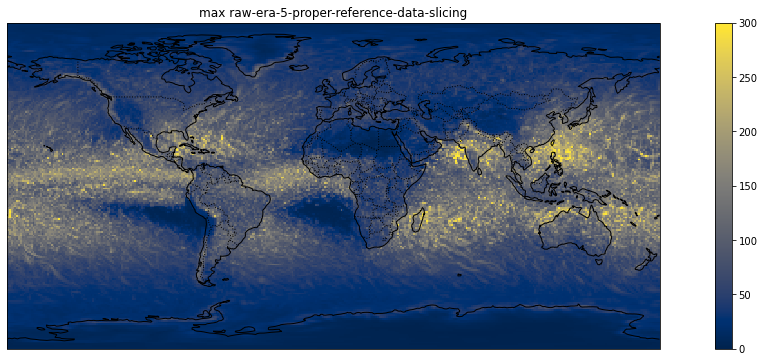

In [47]:
plot_single(ds=read_gcs_zarr(data_dict['coarse']['ERA-5']).sel(time=slice('1994-01-01', '2015-01-15')),
                              variable=variable,
                              metric='max',
                              data_type='raw-era-5-proper-reference-data-slicing', 
                              units=units, 
                              vmin=0,
                              vmax=300,
                              xr_func=None)

### max yearly precip sum ### 

In [32]:
def xr_year_sum(ds):
    ds_c = ds.groupby('time.year').sum()
    ds_c = ds_c.rename(year='time')
    return ds_c

In [ ]:
plot_diagnostic_climo_periods(ds_future=read_gcs_zarr(data_dict['fine']['downscaled'][ssp]),
                              ds_hist=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                              ssp=ssp,
                              years=years,
                              variable=variable,
                              metric='max',
                              data_type='downscaled', 
                              units=units, 
                              vmin=0,
                              vmax=5000,
                              xr_func=xr_year_sum)

In [ ]:
plot_diagnostic_climo_periods(ds_future=read_gcs_zarr(data_dict['coarse']['bias_corrected'][ssp]),
                              ds_hist=read_gcs_zarr(data_dict['coarse']['bias_corrected']['historical']),
                              ssp=ssp,
                              years=years,
                              variable=variable,
                              metric='max',
                              data_type='biascorrected', 
                              units=units, 
                              vmin=0,
                              vmax=5000,
                              xr_func=xr_year_sum)

In [ ]:
plot_diagnostic_climo_periods(ds_future=read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]),
                              ds_hist=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
                              ssp=ssp,
                              years=years,
                              variable=variable,
                              metric='max',
                              data_type='cmip6', 
                              units=units, 
                              vmin=0,
                              vmax=5000,
                              xr_func=xr_year_sum)

### max yearly precip sum - ERA-5 vs historical bias-corrected ### 

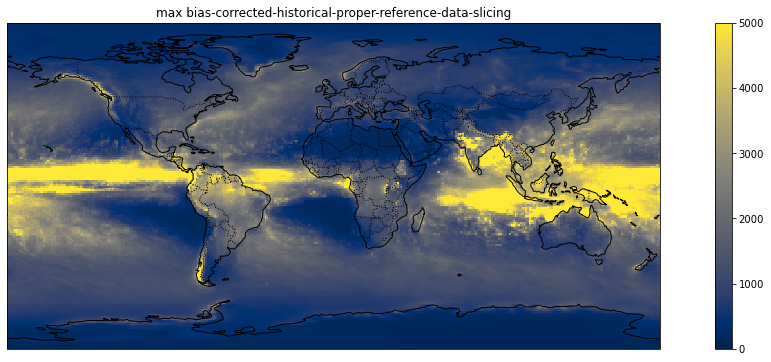

In [46]:
# plot_single(ds=read_gcs_zarr(data_dict['coarse']['ERA-5']),
#                               variable=variable,
#                               metric='mean',
#                               data_type='raw-era-5', 
#                               units=units, 
#                               vmin=0,
#                               vmax=5000,
#                               xr_func=xr_year_sum)


# plot_single(ds=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
#                               variable=variable,
#                               metric='mean',
#                               data_type='cmip6-historical', 
#                               units=units, 
#                               vmin=0,
#                               vmax=5000,
#                               xr_func=xr_year_sum)

plot_single(ds=read_gcs_zarr(data_dict['coarse']['bias_corrected']['historical']),
                              variable=variable,
                              metric='max',
                              data_type='bias-corrected-historical-proper-reference-data-slicing', 
                              units='mm yearly sum', 
                              vmin=0,
                              vmax=5000,
                              xr_func=xr_year_sum)

In [48]:
#### client.restart() # clear all tasks - otherwise cluster won't scale down
client.restart()
cluster.scale(0)
client.close()
cluster.close()